# <center><font color=#01B8AA>Getting the sentiment behind tweets</font></center>

<font color=#FF0000>__! Work in progress !__</font>

This project has been developed with the public dataset "Twitter sentiment analysis" available on kaggle : https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data

I created this notebook in order to get more familiar with NLP techniques. <br>
I will especially test différent models that are usually good with NLP tasks. This is also an opportunity for me to try my first deep learning models using the pytorch library.

## Librairies

In [34]:
import pandas as pd
import numpy as np

import time

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk.stem.porter import * 
from nltk import word_tokenize
# nltk.download('punkt') # To download if not already done
# nltk.download('punkt_tab')
# nltk.download('stopwords')

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from skopt.space import Real, Categorical, Integer

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score

## Data visualization

Let's load the training and testing sets.

In [2]:
training_path = "./twitter_data/twitter_training.csv"
testing_path = "./twitter_data/twitter_validation.csv"

df_train = pd.read_csv(training_path, header=0, names=["tweetId", "entity", "sentiment", "tweet"])
df_test = pd.read_csv(testing_path, header=0, names=["tweetId", "entity", "sentiment", "tweet"])


In [3]:
# LabelEncoding the entity and the sentiment
le_entity = preprocessing.LabelEncoder()
le_entity.fit(df_train.entity)
df_train['entity'] = le_entity.transform(df_train.entity)
df_test['entity'] = le_entity.transform(df_test.entity)

le_sentiment = preprocessing.LabelEncoder()
le_sentiment.fit(df_train.sentiment)
df_train['sentiment'] = le_sentiment.transform(df_train.sentiment)
df_test['sentiment'] = le_sentiment.transform(df_test.sentiment)

In [4]:
# Getting the mapping between the labels and the integers associated for visualizations

entityToInt = dict(zip(le_entity.classes_, le_entity.transform(le_entity.classes_)))
sentimentToInt = dict(zip(le_sentiment.classes_, le_sentiment.transform(le_sentiment.classes_)))

intToEntity = {v: k for k, v in entityToInt.items()}
intToSentiment = {v: k for k, v in sentimentToInt.items()}

In [5]:
print(df_train.describe())
print("\n")
print(df_train.info())

            tweetId        entity    sentiment
count  74681.000000  74681.000000  74681.00000
mean    6432.640149     15.522288      1.62921
std     3740.423819      9.232193      1.06727
min        1.000000      0.000000      0.00000
25%     3195.000000      8.000000      1.00000
50%     6422.000000     16.000000      2.00000
75%     9601.000000     24.000000      3.00000
max    13200.000000     31.000000      3.00000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweetId    74681 non-null  int64 
 1   entity     74681 non-null  int32 
 2   sentiment  74681 non-null  int32 
 3   tweet      73995 non-null  object
dtypes: int32(2), int64(1), object(1)
memory usage: 1.7+ MB
None


In [6]:
print(df_test.describe())
print("\n")
print(df_test.info())

            tweetId      entity   sentiment
count    999.000000  999.000000  999.000000
mean    6435.159159   15.540541    1.668669
std     3728.912226    9.376884    1.058097
min        6.000000    0.000000    0.000000
25%     3241.500000    7.000000    1.000000
50%     6560.000000   15.000000    2.000000
75%     9662.500000   24.000000    3.000000
max    13197.000000   31.000000    3.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweetId    999 non-null    int64 
 1   entity     999 non-null    int32 
 2   sentiment  999 non-null    int32 
 3   tweet      999 non-null    object
dtypes: int32(2), int64(1), object(1)
memory usage: 23.5+ KB
None


When comparing the description of the two tests, we can see that we approximatively have the same proportions of entities and sentiments, so the data has been well split.

In [7]:
# The only null values correspond to the tweet column, we can just drop these rows. We also remove the duplicated rows.
df_train.dropna(axis=0, inplace=True)
df_train.drop_duplicates(inplace=True)

Let's now visualize the balance of the data

C:\Users\marin\AppData\Local\Temp\ipykernel_9140\3804047080.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=60)


<Axes: xlabel='entity', ylabel='count'>

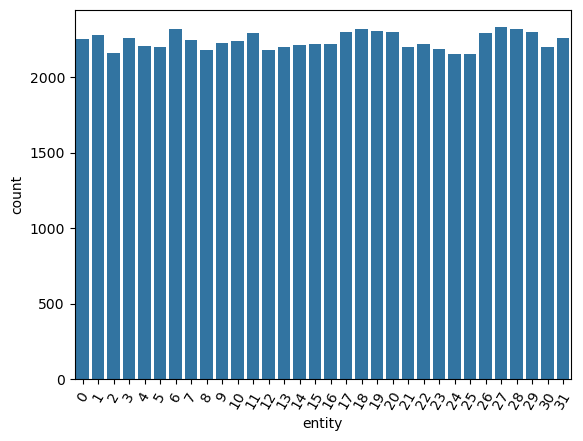

In [10]:
# Plot the distribution of the entities

plot = sns.countplot(df_train, x='entity')
plot.set_xticklabels(plot.get_xticklabels(), rotation=60)
plot

<Axes: xlabel='sentiment', ylabel='count'>

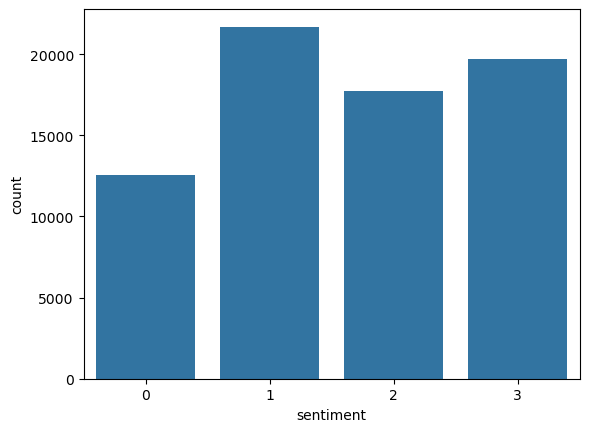

In [10]:
# Plot the distribution of the sentiment

plot = sns.countplot(df_train, x='sentiment')
plot

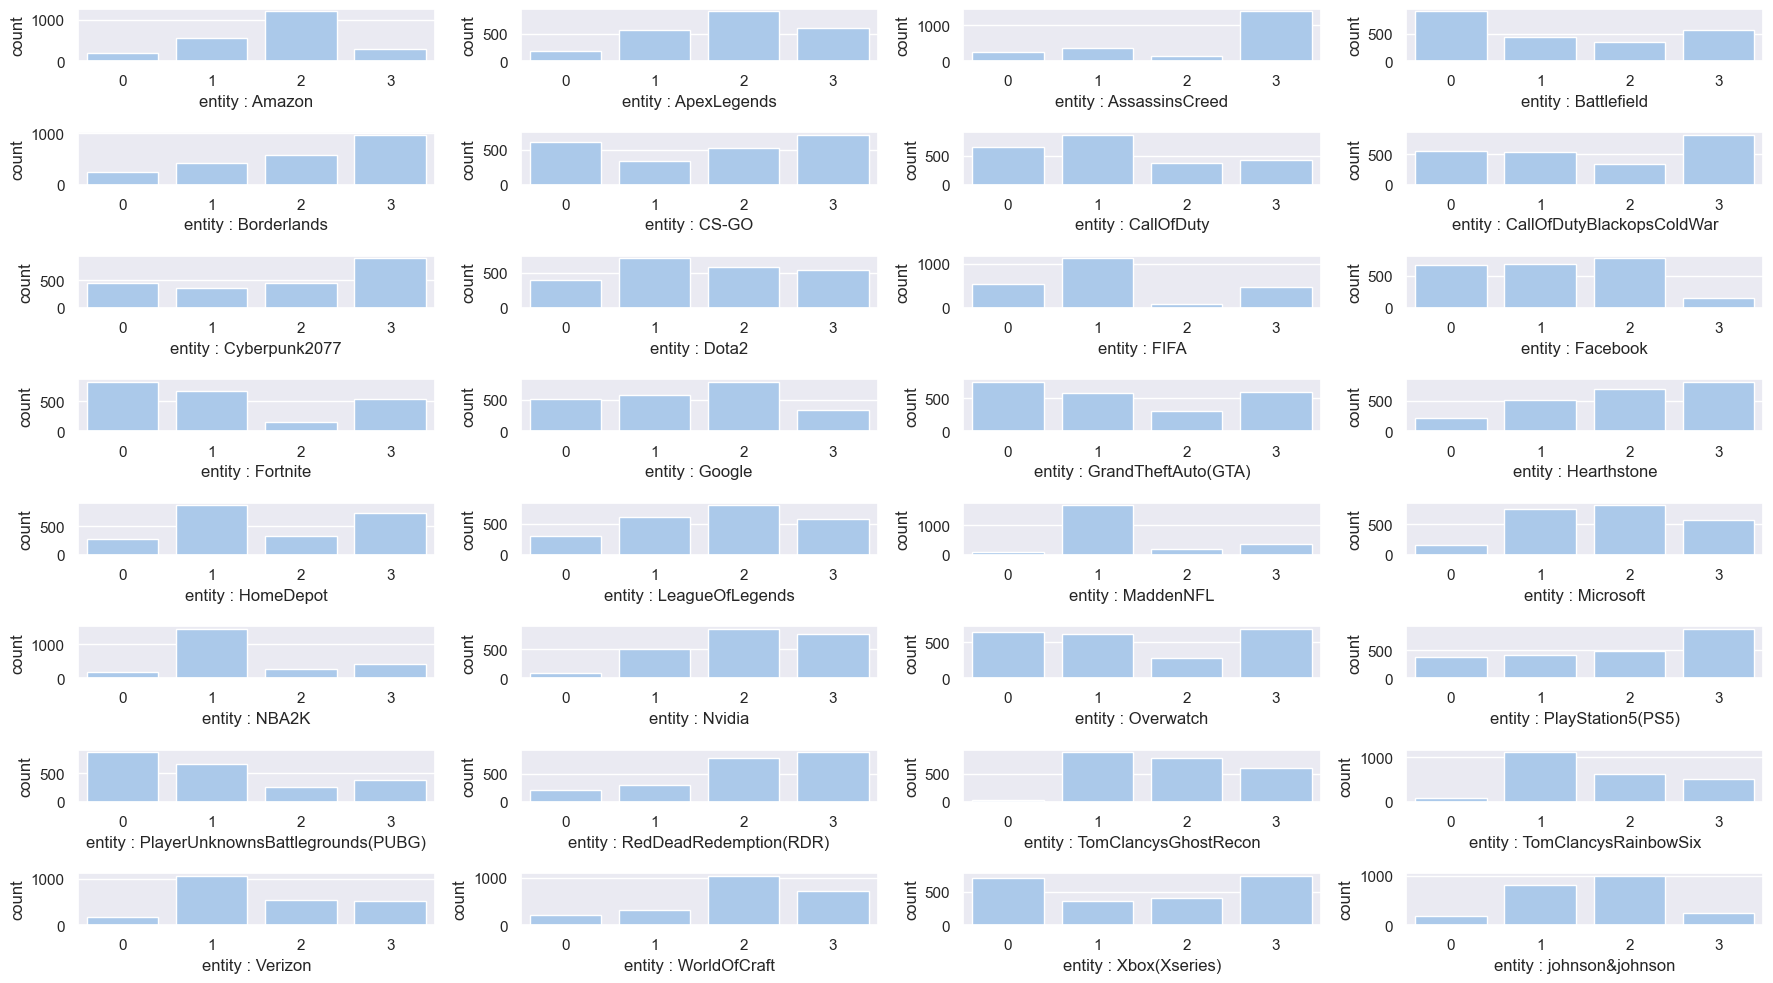

In [11]:
# Plot the distribution of the sentiment feature for each entity 

sns.set_theme(palette="pastel")
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(18, 10))
entity = 0
for r in range(8) :
    for c in range(4) :
        df_subtrain = df_train[df_train['entity']==entity]
        fig.tight_layout()
        sns.countplot(ax=axs[r,c], data=df_subtrain, x='sentiment')
        axs[r,c].set_xlabel(f"entity : {intToEntity[entity]}")
        entity += 1

As a reminder: 
- 0 stands for irrelevant (no sentiment can be associated)
- 1 for a negative sentiment
- 2 for a neutral sentiment
- 3 for a positive sentiment

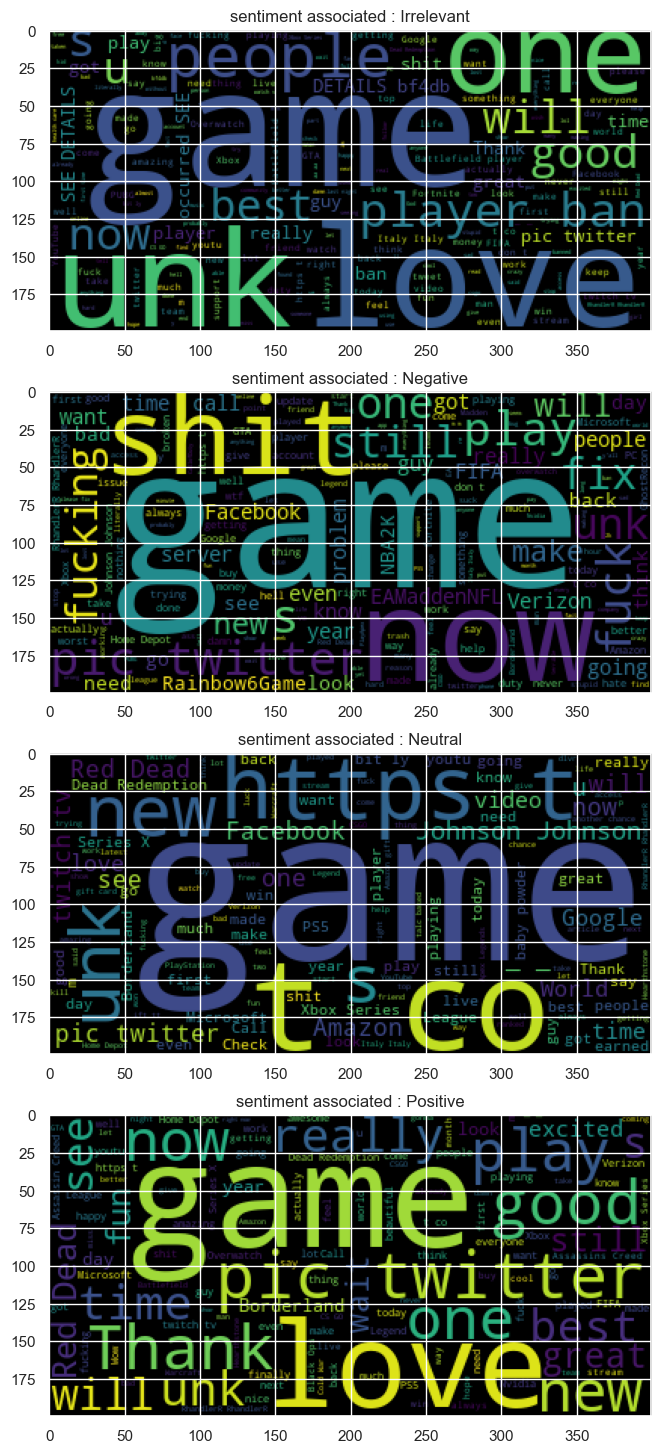

In [11]:
# Plot of wordclouds, depending on sentiment

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(18, 18))
for sentiment in range(4) :
    df_subtrain = df_train[df_train['sentiment'] == sentiment]
    wordcloud = WordCloud().generate(' '.join(df_subtrain['tweet']))
    axs[sentiment].imshow(wordcloud)
    axs[sentiment].set_title(f'sentiment associated : {intToSentiment[sentiment]}')

<bold><font color=#FF0000>plot frequency of words : https://www.kaggle.com/code/mehmetlaudatekman/text-classification-svm-explained</font></bold>

In [9]:
irrelevantTweets = nltk.FreqDist(word  for text in df_train[df_train["sentiment"] == 0]["tweet"] for word in text.lower().split())
negativeTweets = nltk.FreqDist(word  for text in df_train[df_train["sentiment"] == 1]["tweet"] for word in text.lower().split())
neutralTweets = nltk.FreqDist(word  for text in df_train[df_train["sentiment"] == 2]["tweet"] for word in text.lower().split())
positiveTweets = nltk.FreqDist(word for text in df_train[df_train["sentiment"] == 3]["tweet"] for word in text.lower().split())

for sentiment in ['irrelevantTweets', 'negativeTweets', 'neutralTweets', 'positiveTweets'] :
    c=0
    print(f'sentiment analysed : {sentiment}')
    for k, v in sorted(list(globals()[sentiment].items()), key=lambda x:x[1], reverse=True) :
        if c > 10 :
            break
        print(f'{k} : {v}')
        c+=1
    print('\n')


sentiment analysed : irrelevantTweets
the : 7810
to : 4825
a : 4677
and : 4599
i : 4316
of : 3547
is : 3014
for : 2916
in : 2714
/ : 2539
you : 2432


sentiment analysed : negativeTweets
the : 13834
i : 9885
to : 8951
and : 8487
a : 7392
is : 6651
of : 5654
in : 4622
@ : 4622
this : 4492
you : 4220


sentiment analysed : neutralTweets
the : 10376
/ : 7453
to : 7016
and : 6204
a : 5787
i : 5326
of : 4836
for : 3889
in : 3853
. : 3507
is : 3254


sentiment analysed : positiveTweets
the : 11528
i : 8799
to : 7482
and : 6724
a : 5777
of : 4976
for : 4240
is : 4197
this : 3865
in : 3646
my : 3191




These results show us that the data clearly needs to be preprocessed before looking at the most recurrent word (which are stop words for most of them).

__Finally, we can see that the data is quite balanced when looking at features globally. <br>
However, we see that it is not the case when we look at the sentiments for each entity, which suggests  dependency between them. <br>
Finally, we determine another correlation between the tokens in the tweets and the sentiment associated (we retrieve "love" for positive tweets whereas we have some swear words dor the negative tweets for instance).__

## Tweets Preprocessing

Before fitting any model, we first apply some transformations to the data, particularly to the text data.

In [8]:
# Tokenization, stop-word removal, and stemming

def preprocessingTweet(tweet):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    word_tokenize = RegexpTokenizer(r'\w+')
    word_tokens = word_tokenize.tokenize(tweet)
    nostopwords_listsentence = [w for w in word_tokens if not w.lower() in stop_words]
    stem_listsentence = [stemmer.stem(w) for w in nostopwords_listsentence]
    stem_sentence = ' '.join([item for item in stem_listsentence])
    return stem_sentence

df_train['prepropTweet'] = df_train.apply(lambda row: preprocessingTweet(row['tweet']), axis=1)
df_test['prepropTweet'] = df_test.apply(lambda row: preprocessingTweet(row['tweet']), axis=1)
df_train

,tweetId,entity,sentiment,tweet,prepropTweet
0,2401,4,3,I am coming to the borders and I will kill you...,come border kill
1,2401,4,3,im getting on borderlands and i will kill you ...,im get borderland kill
2,2401,4,3,im coming on borderlands and i will murder you...,im come borderland murder
3,2401,4,3,im getting on borderlands 2 and i will murder ...,im get borderland 2 murder
4,2401,4,3,im getting into borderlands and i can murder y...,im get borderland murder
...,...,...,...,...,...
74676,9200,21,3,Just realized that the Windows partition of my...,realiz window partit mac like 6 year behind nv...
74677,9200,21,3,Just realized that my Mac window partition is ...,realiz mac window partit 6 year behind nvidia ...
74678,9200,21,3,Just realized the windows partition of my Mac ...,realiz window partit mac 6 year behind nvidia ...
74679,9200,21,3,Just realized between the windows partition of...,realiz window partit mac like 6 year behind nv...


We can now take again the most frequent words for each sentiment (stop words excluded).

In [11]:
irrelevantTweets = nltk.FreqDist(word  for text in df_train[df_train["sentiment"] == 0]["prepropTweet"] for word in text.lower().split())
negativeTweets = nltk.FreqDist(word  for text in df_train[df_train["sentiment"] == 1]["prepropTweet"] for word in text.lower().split())
neutralTweets = nltk.FreqDist(word  for text in df_train[df_train["sentiment"] == 2]["prepropTweet"] for word in text.lower().split())
positiveTweets = nltk.FreqDist(word for text in df_train[df_train["sentiment"] == 3]["prepropTweet"] for word in text.lower().split())

for sentiment in ['irrelevantTweets', 'negativeTweets', 'neutralTweets', 'positiveTweets'] :
    c=0
    print(f'sentiment analysed : {sentiment}')
    for k, v in sorted(list(globals()[sentiment].items()), key=lambda x:x[1], reverse=True) :
        if c > 10 :
            break
        print(f'{k} : {v}')
        c+=1
    print('\n')

sentiment analysed : irrelevantTweets
com : 1821
player : 1373
game : 1225
ban : 1205
like : 1079
see : 1056
play : 824
love : 786
peopl : 764
go : 763
get : 756


sentiment analysed : negativeTweets
game : 4592
get : 2364
fuck : 2360
play : 2068
com : 1815
like : 1679
shit : 1496
fix : 1449
twitter : 1323
pic : 1286
go : 1274


sentiment analysed : neutralTweets
com : 4102
game : 1925
johnson : 1892
play : 1514
co : 1510
2 : 1486
http : 1383
amazon : 1375
get : 1192
_ : 1078
new : 1071


sentiment analysed : positiveTweets
game : 3254
play : 2490
love : 2028
com : 1846
good : 1564
like : 1429
2 : 1317
thank : 1291
get : 1277
pic : 1271
realli : 1268




This information is way more valuable, we clearly retrieve words matching with the sentiment associated.

In [9]:
# Another processing step required for some models is getting the frequency of each word belonging to the vocabulary (composed by all the training tweets)
cv = CountVectorizer(lowercase=True)
corpusTrain = df_train['prepropTweet'].tolist()

X_tweet_vec = cv.fit_transform(df_train['prepropTweet'])
X_tweet_vec_test = cv.transform(df_test['prepropTweet'])
X_entity_sparse = csr_matrix(df_train['entity'])
X_entity_sparse_test = csr_matrix(df_test['entity'])

X_train_bow = hstack([X_entity_sparse.reshape(-1, 1), X_tweet_vec]) # bow for bag of words
X_test_bow = hstack([X_entity_sparse_test.reshape(-1, 1), X_tweet_vec_test])

y_train = df_train['sentiment']
y_test = df_test['sentiment']

## First Model : Multinomial Naive Bayes

In [23]:
start_time = time.time()

mnb = MultinomialNB()
mnb.fit(X_train_bow, y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print(f"Fitting duration in seconds : {process_time}")

Fitting duration in seconds : 0.03


F1 score : 0.7773281903073835
Precision score : 0.7968196220727023
Recall score : 0.7725290965078158


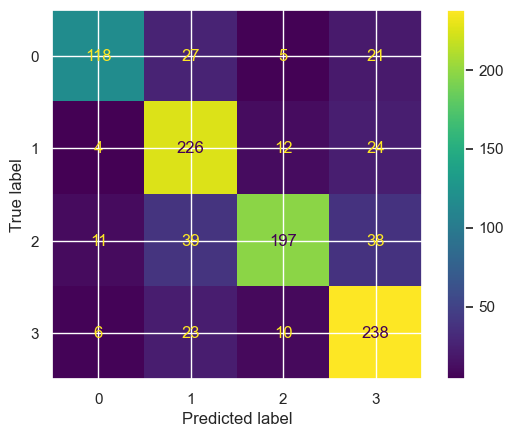

In [24]:
y_pred_mnb = mnb.predict(X_test_bow)

cm_mnb = confusion_matrix(y_test, y_pred_mnb)
disp_mnb = ConfusionMatrixDisplay(confusion_matrix=cm_mnb,
                              display_labels=mnb.classes_)
disp_mnb.plot()


f1_mnb = f1_score(y_test, y_pred_mnb, average='macro')
precision_mnb = precision_score(y_test, y_pred_mnb, average='macro')
recall_mnb = recall_score(y_test, y_pred_mnb, average='macro')
print(f'F1 score : {f1_mnb}')
print(f'Precision score : {precision_mnb}')
print(f'Recall score : {recall_mnb}')

We can see that the basic Multinomial Naive Bayes model works well with the preprocessed data.

## Second model : Support Vector Classification

In [25]:
start_time = time.time()

svc = SVC(random_state=1)
svc.fit(X_train_bow,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print(f"Fitting duration in seconds : {process_time}")

Fitting duration in seconds : 513.76


F1 score : 0.6588035710538206
Precision score : 0.7094501967993148
Recall score : 0.6543429874324802


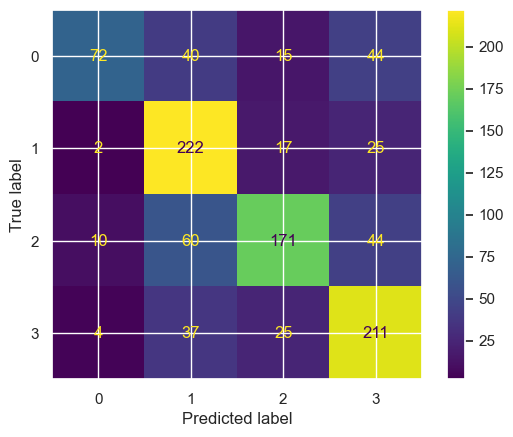

In [26]:
y_pred_svc = svc.predict(X_test_bow)

cm_svc = confusion_matrix(y_test, y_pred_svc)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc,
                              display_labels=svc.classes_)
disp_svc.plot()


f1_svc= f1_score(y_test, y_pred_svc, average='macro')
precision_svc = precision_score(y_test, y_pred_svc, average='macro')
recall_svc = recall_score(y_test, y_pred_svc, average='macro')
print(f'F1 score : {f1_svc}')
print(f'Precision score : {precision_svc}')
print(f'Recall score : {recall_svc}')

The basic SVC model isn't as performant as the basic the multinomial naive bayes we created just before. <br>
Let's try to change the hyperparameters a bit.

In [12]:
start_time = time.time()

optsvc = BayesSearchCV(
     SVC(),
     {
         'C': Real(1e-1, 1e+1, prior='log-uniform'),
         'degree': Integer(2,5),
         'kernel': Categorical(['linear', 'poly', 'rbf']),
     },
     n_iter=32,
     random_state=0
)

optsvc.fit(X_train_bow,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print(f"Fitting duration in seconds : {process_time}")

Fitting duration in seconds : 74022.22


F1 score : 0.8737903554530833
Precision score : 0.884404088516319
Recall score : 0.8688364262038972


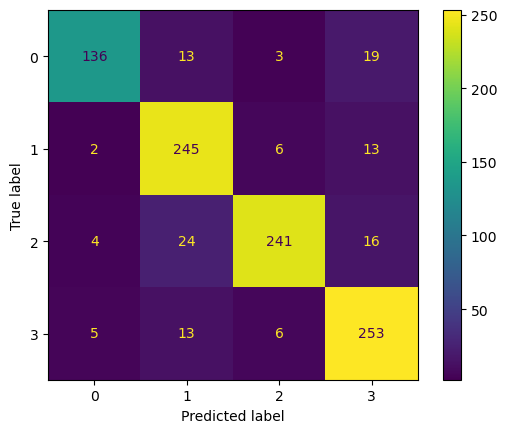

In [13]:
y_pred_optsvc = optsvc.predict(X_test_bow)

cm_optsvc = confusion_matrix(y_test, y_pred_optsvc)
disp_optsvc = ConfusionMatrixDisplay(confusion_matrix=cm_optsvc,
                              display_labels=optsvc.classes_)
disp_optsvc.plot()


f1_optsvc= f1_score(y_test, y_pred_optsvc, average='macro')
precision_optsvc = precision_score(y_test, y_pred_optsvc, average='macro')
recall_optsvc = recall_score(y_test, y_pred_optsvc, average='macro')
print(f'F1 score : {f1_optsvc}')
print(f'Precision score : {precision_optsvc}')
print(f'Recall score : {recall_optsvc}')

Unlike the first time, we can see that with good parameters we can have a model that even outperforms the classic multinomial naive bayes algorithm.

In [18]:
# Here we retrieve the hyperparameters of the best model trained
optsvc.best_params_

OrderedDict([('C', 0.1), ('degree', 2), ('kernel', 'linear')])

In [15]:
# We save the model to be able to use it directly later (as the training time was quite long ~20h)
joblib.dump(optsvc, 'bayes_svc_model.pkl')

['bayes_svc_model.pkl']

## Third model : a simple Convolutional Neural Network

First we can just check that the GPU is recognized (so it can be used for next computations).

In [12]:
torch.cuda.is_available()

True

In [13]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4070 Laptop GPU'

Let's create the vocabulary (got from the training set) to prepare the word embedding step, and create the sequences associated to each tweet (they have to be the same size so we pad them) that we will be input 

In [10]:
train_docs = df_train['prepropTweet'].tolist()
train_docs = ' '.join(map(str, train_docs))

tokens = list(set(train_docs.split(' ')))
voc = {v: k for k, v in dict(enumerate(tokens)).items()}
invertVoc = {v: k for k, v in voc.items()}

df_train = df_train.drop(df_train[df_train.prepropTweet == ''].index) # Removing the rows for which there is no relevant word (prepropTweet == '') beacuase we cannot split it as a sequence
def tweetToSeq (preproptweet) :
    seq = str.split(preproptweet, sep=' ')
    seqIdx = [voc[w] if w in voc else 0 for w in seq] # Getting the index of each token from the vocabulary, pass for new tokens in test set
    seqIdx += [0] * (len(max(df_train.prepropTweet, key=len)) - len(seq)) # Padding to the size of the longest tweet
    return seqIdx

df_train['seqIdx'] = df_train.apply(lambda row: tweetToSeq(row['prepropTweet']), axis=1)
df_test['seqIdx'] = df_test.apply(lambda row: tweetToSeq(row['prepropTweet']), axis=1)

df_train

,tweetId,entity,sentiment,tweet,prepropTweet,SeqIdx
0,2401,4,3,I am coming to the borders and I will kill you...,come border kill,"[5869, 22287, 17043, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,2401,4,3,im getting on borderlands and i will kill you ...,im get borderland kill,"[5149, 13969, 20273, 17043, 0, 0, 0, 0, 0, 0, ..."
2,2401,4,3,im coming on borderlands and i will murder you...,im come borderland murder,"[5149, 5869, 20273, 6945, 0, 0, 0, 0, 0, 0, 0,..."
3,2401,4,3,im getting on borderlands 2 and i will murder ...,im get borderland 2 murder,"[5149, 13969, 20273, 2394, 6945, 0, 0, 0, 0, 0..."
4,2401,4,3,im getting into borderlands and i can murder y...,im get borderland murder,"[5149, 13969, 20273, 6945, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...,...,...
74676,9200,21,3,Just realized that the Windows partition of my...,realiz window partit mac like 6 year behind nv...,"[23567, 8071, 10704, 8955, 1173, 2928, 11728, ..."
74677,9200,21,3,Just realized that my Mac window partition is ...,realiz mac window partit 6 year behind nvidia ...,"[23567, 8955, 8071, 10704, 2928, 11728, 7634, ..."
74678,9200,21,3,Just realized the windows partition of my Mac ...,realiz window partit mac 6 year behind nvidia ...,"[23567, 8071, 10704, 8955, 2928, 11728, 7634, ..."
74679,9200,21,3,Just realized between the windows partition of...,realiz window partit mac like 6 year behind nv...,"[23567, 8071, 10704, 8955, 1173, 2928, 11728, ..."


In [12]:
# We just check if the test contains Tweets that doesn't have relevant content (nothing after removing the stop words) or if it has tweets 
# that only contains new words (out of the vocabulary)

df_test_emptyTweet =df_test[df_test.prepropTweet == '']
df_test_emptySeq = df_test[df_test.seqIdx.apply(lambda x: x == [0] * len(max(df_train.prepropTweet, key=len)))  ]
df_test_empty = pd.concat([df_test_emptyTweet, df_test_emptySeq], axis=0)
df_test_empty = df_test_empty[~df_test_empty.index.duplicated(keep='first')]

df_test_empty


,tweetId,entity,sentiment,tweet,prepropTweet,SeqIdx
331,8788,20,1,Not this again,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


We can see we do have one problematic row, which preprocessed Tweet is empty. Therefore, we have to make a choice about iis classification. Whe might want to choose the irrelevant or the neutral class, depending on the major one for the entity associated.

In [14]:
# We remove the problematic rows with only new vocabulary from the training set (we have already removed the empty prepropTweets before)
df_test.drop(index=df_test_empty.index.values, inplace=True)

In [11]:
df_train.columns

Index(['tweetId', 'entity', 'sentiment', 'tweet', 'prepropTweet', 'SeqIdx'], dtype='object')

In [49]:
# We first split our train data in train / validation 

X_train, X_valid, y_train, y_valid = train_test_split(df_train.loc[:, df_train.columns != 'sentiment'], df_train['sentiment'], test_size=0.33, random_state=1)

# Then we convert them into tensors
seq_idx_list_train = X_train['seqIdx'].tolist()
Xtrain_tensor = torch.tensor(seq_idx_list_train)
ytrain_tensor = torch.tensor(y_train.tolist())

seq_idx_list_valid = X_valid['seqIdx'].tolist()
Xvalid_tensor = torch.tensor(seq_idx_list_valid)
yvalid_tensor = torch.tensor(y_valid.tolist())

seq_idx_list_test = df_test['seqIdx'].tolist()
Xtest_tensor = torch.tensor(seq_idx_list_test)
ytest_tensor = torch.tensor(df_test['sentiment'].tolist())

In [47]:
# We create the function to one-hot encode our target variable : sentiment, and therefore to be able to use CrossEntropy.
def one_hot_encode(labels, num_classes):
    one_hot = torch.zeros(labels.size(0), num_classes)
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    one_hot = one_hot.long()
    return one_hot

In [55]:
# Get the number of possible sentiments 
nbr_classes = len(df_train["sentiment"].unique())

ytrain_tensor = one_hot_encode(ytrain_tensor, nbr_classes)
yvalid_tensor = one_hot_encode(yvalid_tensor, nbr_classes)
ytest_tensor = one_hot_encode(ytest_tensor, nbr_classes)

#Move tensors to GPU
Xtrain_tensor = Xtrain_tensor.to('cuda')
ytrain_tensor = ytrain_tensor.to('cuda')

Xvalid_tensor = Xvalid_tensor.to('cuda')
yvalid_tensor = yvalid_tensor.to('cuda')

Xtest_tensor = Xtest_tensor.to('cuda')
ytest_tensor = ytest_tensor.to('cuda')

# Finally we create dataloaders for batching
train_dataset = TensorDataset(Xtrain_tensor, ytrain_tensor)
val_dataset = TensorDataset(Xvalid_tensor, yvalid_tensor)
test_dataset = TensorDataset(Xtest_tensor, ytest_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [38]:
# We define the model (and paremeters)
class EmbNN(nn.Module):
    def __init__(self, hidden_layer1 = 100 ):
        super().__init__()
        self.embedding = torch.nn.Embedding(len(tokens), len(max(df_train.prepropTweet, key=len)), padding_idx=0)
        self.lin1 = nn.Linear(len(max(df_train.prepropTweet, key=len)) , hidden_layer1) 
        self.lin2 = nn.Linear(hidden_layer1, nbr_classes)  # Input: 10 features, Output: 1 feature


    def forward(self, input):
        embedded = self.embedding(input)
        lin = self.lin1(embedded)
        output = self.lin2(lin)
        return output


class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=10):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True


In [59]:
model = EmbNN() 
model = nn.DataParallel(model) # Wrap the model with DataParallel
model = model.to('cuda') # Move the model to the GPU

early_stopping = EarlyStopping(tolerance=5, min_delta=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

t0 = time.time()


epochs = 2
for epoch in range(epochs):
    model.train() # The model is ready to train
    
    print(f"Epoch {i+1}")
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch 1
Epoch [1/2], Loss: 3.4616
Epoch 1
Epoch [2/2], Loss: 2.3723
